# Phishing URL Detection - Complete Training Pipeline

## 🎯 Overview
This notebook trains a Random Forest classifier to detect phishing URLs using 19 URL-based features.

## ⚡ Key Features:
- **No webpage fetching** - works with just the URL
- **19 engineered features** - domain, TLD, path, protocol analysis
- **Random Forest model** - balanced, high accuracy
- **Fixed TrustedBrandOnHTTP logic** - no false positives on legitimate sites

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from pathlib import Path
import re
from difflib import SequenceMatcher
from urllib.parse import urlparse
import warnings
warnings.filterwarnings('ignore')

# Try to import tldextract
try:
    import tldextract
    HAS_TLDEXTRACT = True
    print("✅ tldextract library found")
except ImportError:
    HAS_TLDEXTRACT = False
    print("⚠️  tldextract not found - using fallback TLD extraction")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")

✅ tldextract library found
✅ All libraries imported successfully


## 2. Define Feature Extraction Functions

In [2]:
# Feature extraction constants
COMMON_LEGIT_TLDS = {
    "com": 0.9, "org": 0.85, "net": 0.8, "edu": 0.95, "gov": 0.97,
    "co": 0.7, "uk": 0.8, "de": 0.75, "fr": 0.75, "ca": 0.8
}

SUSPICIOUS_TLDS = {"xyz", "tk", "ml", "ga", "cf", "ru", "cn", "top", "gq", "pw"}

BRANDS = [
    "paypal", "google", "facebook", "amazon", "instagram", "bank", 
    "sbi", "hdfc", "icici", "apple", "microsoft", "netflix", "ebay",
    "myntra", "flipkart", "wikipedia", "github", "linkedin", "twitter"
]

PHISHING_KEYWORDS = ["login", "secure", "account", "verify", "bank", "update", "confirm"]


def simple_tld_extract(url):
    """Fallback TLD extraction if tldextract is not available"""
    parsed = urlparse(url)
    domain = parsed.netloc or parsed.path.split('/')[0]
    domain = domain.split(':')[0]
    parts = domain.split('.')
    
    if len(parts) >= 2:
        return {
            'domain': parts[-2],
            'suffix': parts[-1],
            'subdomain': '.'.join(parts[:-2]) if len(parts) > 2 else ''
        }
    return {'domain': domain, 'suffix': '', 'subdomain': ''}


def _normalize_url(url: str) -> str:
    """Normalize URL so trailing slash doesn't change features."""
    url = url.strip()
    parsed = urlparse(url)
    if parsed.path == "/" and not parsed.query and not parsed.fragment:
        url = url.rstrip("/")
    return url


def extract_features(url: str) -> dict:
    """
    Extract URL-based features for phishing detection.
    Returns 19 features that can be extracted without fetching the webpage.
    """
    if not url or not isinstance(url, str):
        url = str(url) if url else ""
    
    url = _normalize_url(url)
    
    # Parse URL
    if HAS_TLDEXTRACT:
        ext = tldextract.extract(url)
        domain = ext.domain
        tld = ext.suffix.lower()
        subdomain = ext.subdomain
    else:
        ext_dict = simple_tld_extract(url)
        domain = ext_dict['domain']
        tld = ext_dict['suffix'].lower()
        subdomain = ext_dict['subdomain']
    
    parsed = urlparse(url)
    
    # Character repetition
    repeated_chars = sum(1 for i in range(1, len(url)) if url[i] == url[i - 1])
    
    # Similarity to phishing keywords
    max_similarity = max(
        SequenceMatcher(None, url.lower(), kw).ratio()
        for kw in PHISHING_KEYWORDS
    )
    url_similarity_index = max_similarity * 100
    
    # Protocol check
    has_https = 1 if parsed.scheme == "https" else 0
    
    # Subdomain analysis
    subdomain_count = len(subdomain.split('.')) if subdomain else 0
    
    # Character analysis
    digit_count = sum(c.isdigit() for c in url)
    special_char_count = sum(c in "@?=-_&" for c in url)
    
    # IP address check
    is_ip = bool(re.match(r"^\d{1,3}(\.\d{1,3}){3}$", domain))
    
    # Path analysis
    path_length = len(parsed.path) if parsed.path else 0
    path_depth = parsed.path.count('/') if parsed.path else 0
    
    # Suspicious patterns
    has_at_symbol = 1 if '@' in url else 0
    double_slash_redirecting = 1 if url.count('//') > 1 else 0

    # Known brand check
    has_brand = int(any(b in domain.lower() for b in BRANDS))
    
    # FIXED: TrustedBrandOnHTTP - only flag suspicious subdomain usage
    has_suspicious_subdomain = subdomain and any(b in subdomain.lower() for b in BRANDS)
    trusted_brand_on_http = 1 if (has_suspicious_subdomain and has_https == 0) else 0

    return {
        "URLLength": len(url),
        "DomainLength": len(domain),
        "IsDomainIP": int(is_ip),
        "URLSimilarityIndex": url_similarity_index,
        "CharContinuationRate": repeated_chars / max(len(url), 1),
        "TLDLegitimateProb": COMMON_LEGIT_TLDS.get(tld, 0.05),
        "HasBrandName": has_brand,
        "HyphenCount": domain.count("-"),
        "SuspiciousTLD": int(tld in SUSPICIOUS_TLDS),
        "HasHTTPS": has_https,
        "TrustedBrandOnHTTP": trusted_brand_on_http,
        "SubdomainLevel": subdomain_count,
        "PathLength": path_length,
        "PathDepth": path_depth,
        "DigitCount": digit_count,
        "SpecialCharCount": special_char_count,
        "HasAtSymbol": has_at_symbol,
        "DoubleSlashRedirecting": double_slash_redirecting,
        "PrefixSuffix": 1 if '-' in domain else 0,
    }

print("✅ Feature extraction functions defined")
print(f"   Total features: 19")

✅ Feature extraction functions defined
   Total features: 19


## 3. Load Dataset

Make sure you have the dataset at: `../data/raw/PhiUSIIL_Phishing_URL_Dataset.csv`

In [3]:
# Load dataset
DATA_PATH = Path("../data/raw/PhiUSIIL_Phishing_URL_Dataset.csv")

if not DATA_PATH.exists():
    print(f"❌ Dataset not found at: {DATA_PATH.absolute()}")
    print("   Please place the dataset file there and try again.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Dataset loaded from: {DATA_PATH}")
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns[:10])}...")
    print(f"\nClass distribution:")
    print(df['label'].value_counts())

✅ Dataset loaded from: ..\data\raw\PhiUSIIL_Phishing_URL_Dataset.csv

Dataset shape: (235795, 56)
Columns: ['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb']...

Class distribution:
label
1    134850
0    100945
Name: count, dtype: int64


## 4. Extract Features from URLs

In [4]:
# Extract features from all URLs
print("Extracting features from URLs...")
feature_list = []
for url in df['URL']:
    features = extract_features(url)
    feature_list.append(features)

# Create feature DataFrame
X = pd.DataFrame(feature_list)
y = 1-df['label']

print(f"\n✅ Features extracted: {X.shape}")
print(f"   Features: {list(X.columns)}")
print(f"\nFirst few rows:")
print(X.head())

Extracting features from URLs...

✅ Features extracted: (235795, 19)
   Features: ['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'HasBrandName', 'HyphenCount', 'SuspiciousTLD', 'HasHTTPS', 'TrustedBrandOnHTTP', 'SubdomainLevel', 'PathLength', 'PathDepth', 'DigitCount', 'SpecialCharCount', 'HasAtSymbol', 'DoubleSlashRedirecting', 'PrefixSuffix']

First few rows:
   URLLength  DomainLength  IsDomainIP  URLSimilarityIndex  \
0         32            16           0           22.222222   
1         24             9           0           20.000000   
2         30            12           0           21.621622   
3         27            11           0           18.181818   
4         34            18           0           15.384615   

   CharContinuationRate  TLDLegitimateProb  HasBrandName  HyphenCount  \
0              0.125000               0.90             1            0   
1              0.166667               0.75           

## 5. Train-Test Split

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (188636, 19)
Test set: (47159, 19)


## 6. Train Logistic Regression Baseline Model

We'll first train a simple Logistic Regression model as a baseline to compare against Random Forest.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

print("=" * 70)
print("TRAINING LOGISTIC REGRESSION BASELINE MODEL")
print("=" * 70)

# Scale features for Logistic Regression (important for convergence)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    solver='lbfgs'
)

print("Training model...")
lr_model.fit(X_train_scaled, y_train)
print("✅ Model trained successfully\n")

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print("=" * 70)
print("LOGISTIC REGRESSION - MODEL PERFORMANCE (BASELINE)")
print("=" * 70)
print(f"Accuracy:  {accuracy_lr:.4f} ({accuracy_lr*100:.2f}%)")
print(f"Precision: {precision_lr:.4f} ({precision_lr*100:.2f}%)")
print(f"Recall:    {recall_lr:.4f} ({recall_lr*100:.2f}%)")
print(f"F1-Score:  {f1_lr:.4f} ({f1_lr*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc_lr:.4f} ({roc_auc_lr*100:.2f}%)")
print("=" * 70)

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(cm_lr)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Legitimate', 'Phishing']))

TRAINING LOGISTIC REGRESSION BASELINE MODEL
Training model...
✅ Model trained successfully

LOGISTIC REGRESSION - MODEL PERFORMANCE (BASELINE)
Accuracy:  0.9895 (98.95%)
Precision: 0.9947 (99.47%)
Recall:    0.9806 (98.06%)
F1-Score:  0.9876 (98.76%)
ROC-AUC:   0.9953 (99.53%)

Confusion Matrix:
[[26865   105]
 [  392 19797]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      1.00      0.99     26970
    Phishing       0.99      0.98      0.99     20189

    accuracy                           0.99     47159
   macro avg       0.99      0.99      0.99     47159
weighted avg       0.99      0.99      0.99     47159



### Visualize Logistic Regression Performance

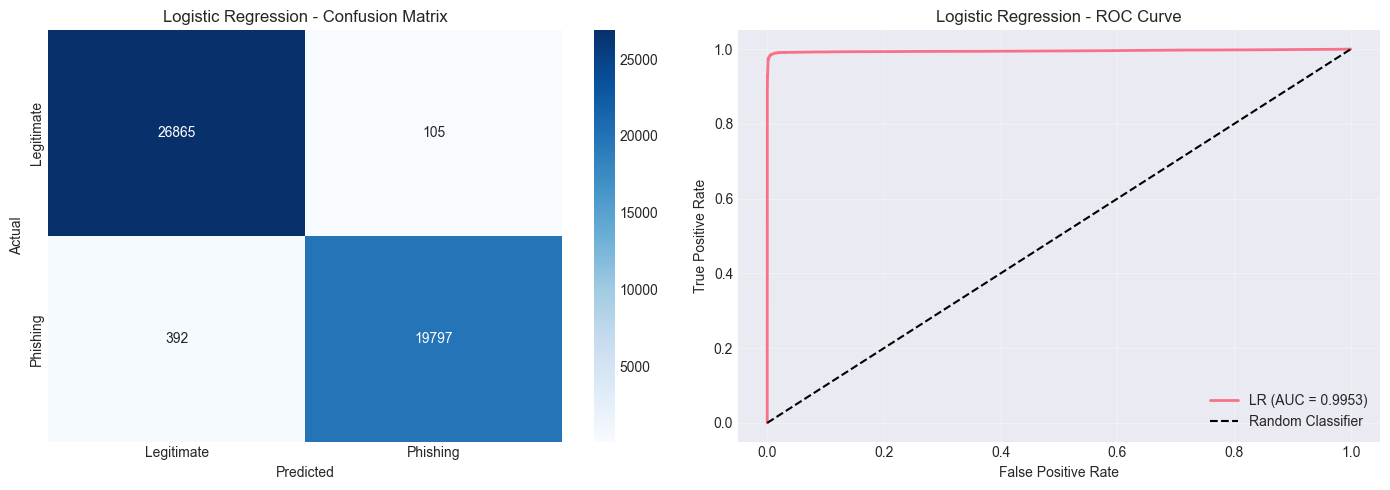

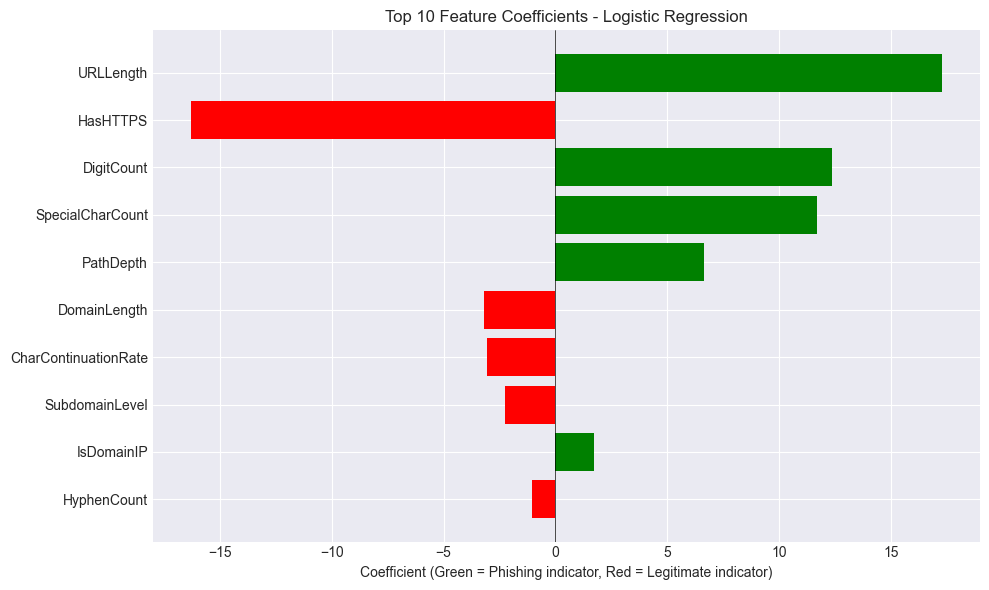

In [7]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Legitimate', 'Phishing'])
axes[0].set_yticklabels(['Legitimate', 'Phishing'])

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
axes[1].plot(fpr_lr, tpr_lr, label=f'LR (AUC = {roc_auc_lr:.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Logistic Regression - ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature coefficients (top 10)
feature_coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
})
feature_coefs['abs_coef'] = abs(feature_coefs['coefficient'])
feature_coefs = feature_coefs.sort_values('abs_coef', ascending=False)

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in feature_coefs['coefficient'][:10]]
plt.barh(feature_coefs['feature'][:10], feature_coefs['coefficient'][:10], color=colors)
plt.xlabel('Coefficient (Green = Phishing indicator, Red = Legitimate indicator)')
plt.title('Top 10 Feature Coefficients - Logistic Regression')
plt.gca().invert_yaxis()
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## 12. Train Random Forest Model

In [8]:
# Train Random Forest
print("Training Random Forest model...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("✅ Model trained successfully!")

Training Random Forest model...
✅ Model trained successfully!


## 12. Evaluate Model

In [9]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 70)
print("MODEL PERFORMANCE")
print("=" * 70)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("=" * 70)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

MODEL PERFORMANCE
Accuracy:  0.9918
Precision: 0.9981
Recall:    0.9828
F1-Score:  0.9904
ROC-AUC:   0.9974

Detailed Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      1.00      0.99     26970
    Phishing       1.00      0.98      0.99     20189

    accuracy                           0.99     47159
   macro avg       0.99      0.99      0.99     47159
weighted avg       0.99      0.99      0.99     47159



## 12. Feature Importance


Top 10 Most Important Features:
                 feature  importance
9               HasHTTPS    0.374481
4   CharContinuationRate    0.171415
14            DigitCount    0.145967
0              URLLength    0.081721
12            PathLength    0.039975
11        SubdomainLevel    0.039222
15      SpecialCharCount    0.033304
13             PathDepth    0.033144
1           DomainLength    0.031680
8          SuspiciousTLD    0.017576


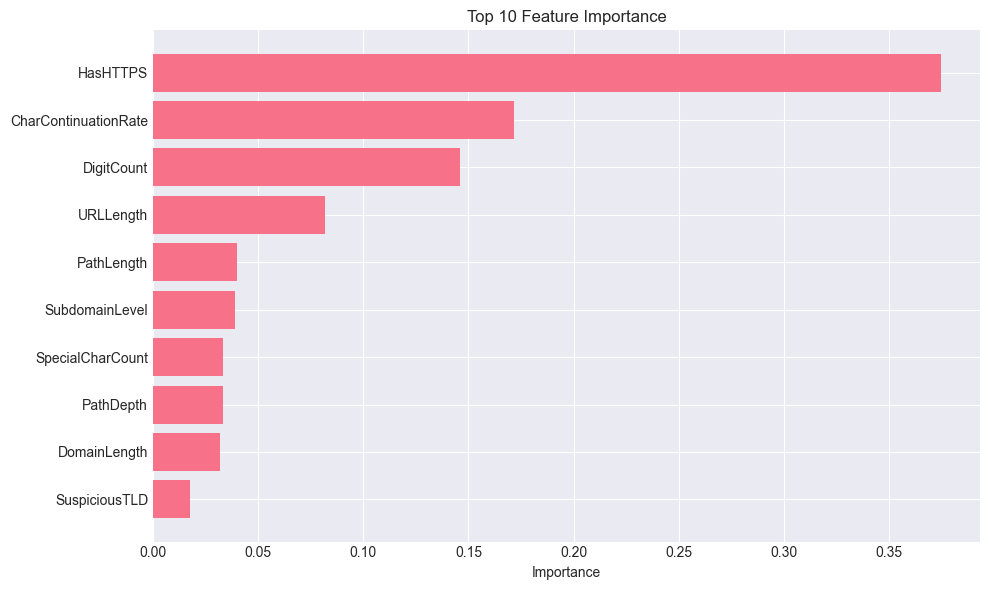

In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 12. Save Model

In [11]:
# Create models directory in project root
MODEL_PATH = Path("../models/url_rf_model.pkl")
MODEL_PATH.parent.mkdir(exist_ok=True, parents=True)

# Create model bundle with metadata
model_bundle = {
    "model": rf_model,
    "features": list(X.columns),
    "accuracy": accuracy,
    "f1_score": f1,
    "roc_auc": roc_auc,
}

# Save model
joblib.dump(model_bundle, MODEL_PATH)

print("=" * 70)
print("MODEL SAVED")
print("=" * 70)
print(f"Location: {MODEL_PATH.absolute()}")
print(f"File size: {MODEL_PATH.stat().st_size / 1024 / 1024:.2f} MB")
print("=" * 70)

MODEL SAVED
Location: c:\Users\sriji\Projects\phishing_url_detection\src\..\models\url_rf_model.pkl
File size: 2.68 MB


## 12. Test on Sample URLs

In [12]:
# Test URLs
test_urls = [
    ("https://www.google.com", "LEGITIMATE"),
    ("https://www.github.com", "LEGITIMATE"),
    ("http://www.amazon.com", "LEGITIMATE"),
    ("http://secure-paypal-login.xyz", "PHISHING"),
    ("https://192.168.1.1/login", "PHISHING"),
    ("http://paypal-secure.verify-account.ml", "PHISHING"),
]

print("=" * 70)
print("TESTING ON SAMPLE URLs")
print("=" * 70)

results = []
for url, expected in test_urls:
    features = extract_features(url)
    X_url = pd.DataFrame([features])[list(X.columns)]
    
    pred_proba = rf_model.predict_proba(X_url)[0][1]
    pred = "PHISHING" if pred_proba >= 0.5 else "LEGITIMATE"
    
    status = "✅" if pred == expected else "❌"
    results.append((status, url, expected, pred, pred_proba))
    
    print(f"\n{status} URL: {url}")
    print(f"   Expected: {expected}, Predicted: {pred} (Risk: {pred_proba:.4f})")

correct = sum(1 for r in results if r[0] == "✅")
print(f"\n{'=' * 70}")
print(f"Test Results: {correct}/{len(results)} correct ({correct/len(results)*100:.1f}%)")
print(f"{'=' * 70}")

TESTING ON SAMPLE URLs

✅ URL: https://www.google.com
   Expected: LEGITIMATE, Predicted: LEGITIMATE (Risk: 0.0376)

✅ URL: https://www.github.com
   Expected: LEGITIMATE, Predicted: LEGITIMATE (Risk: 0.0376)

❌ URL: http://www.amazon.com
   Expected: LEGITIMATE, Predicted: PHISHING (Risk: 0.9148)

✅ URL: http://secure-paypal-login.xyz
   Expected: PHISHING, Predicted: PHISHING (Risk: 0.9998)

✅ URL: https://192.168.1.1/login
   Expected: PHISHING, Predicted: PHISHING (Risk: 1.0000)

✅ URL: http://paypal-secure.verify-account.ml
   Expected: PHISHING, Predicted: PHISHING (Risk: 0.9973)

Test Results: 5/6 correct (83.3%)


## 12. Use the Model for Predictions

In [13]:
# Load model and predict
import joblib
from pathlib import Path
import pandas as pd
from features import extract_features

# Load the model
MODEL_PATH = Path("../models/url_rf_model.pkl")
model_bundle = joblib.load(MODEL_PATH)

# Test it
url = "https://www.google.com"
features = extract_features(url)
X = pd.DataFrame([features])[model_bundle["features"]]
risk_score = model_bundle["model"].predict_proba(X)[0][1]
prediction = "PHISHING" if risk_score >= 0.5 else "LEGITIMATE"

print(f"URL: {url}")
print(f"Prediction: {prediction}")
print(f"Risk Score: {risk_score:.2%}")

print("\n" + "=" * 70)
print("For interactive prediction, run from terminal:")
print("  cd src && python predict_url.py -i")
print("=" * 70)

URL: https://www.google.com
Prediction: LEGITIMATE
Risk Score: 3.76%

For interactive prediction, run from terminal:
  cd src && python predict_url.py -i
